In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:



def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    return 2 * concordance_index_censored(e, y, x)[0] - 1


def bootstrap_dxy(df, n=1):
    """ Boostrap and calculate Dxy """
    e, y, x = df.columns
    #print(df.columns)
    result = []
    result.append(Dxy(df[e], df[y], df[x]))
    return result
    # resample n times
    for i in range(n):
        sample = df.sample(df.shape[0], replace=True)
        #print(sample)
        # calculate Dxy
        result.append(Dxy(sample[e], sample[y], sample[x]))
    return result

def apply_stats_for_each_value(df, fmap, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    
    return result, groups

In [5]:
df = pd.DataFrame({'E': [ 1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0,	1,	1,	1,	1,	1,	1,	1,	], 'Y' : [620, 797, 3218, 1043, 210, 2314, 977, 1003, 609, 1587, 1473, 1216, 2292, 437, 1076, 737, 1516, 372, 1331, 303,]})
df['E'] = df['E'].astype(bool)


In [6]:
# generate random risk factor
df['Z']=df['Y']*10
df

,E,Y,Z
0,True,620,6200
1,True,797,7970
2,True,3218,32180
3,True,1043,10430
4,True,210,2100
5,True,2314,23140
6,True,977,9770
7,True,1003,10030
8,True,609,6090
9,True,1587,15870


In [7]:
def f_map(x):
    a = int(x['Z'])
    if a < 10000:
        return 2
    if 10000 <= a < 20000:
        return 1
    else:
        return 0

condition_names = {2 : 'Z < 10000', 1: '10000 <= Z < 20000', 0: 'Z >=20000'}

S1, S2 = apply_stats_for_each_value(df, f_map, condition_names)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,20.0,1.0,2.80274,0.66,0.64,0.67


,Number of patiets,"Survival years, median"
agg,,
Z >=20000,3,2314.0
10000 <= Z < 20000,8,1273.5
Z < 10000,9,609.0


(None, None)

In [1]:
merged_df_filename='../data/commits_with_published_cve-merge-cve_info.parquet'
merged_df_filename

'../data/commits_with_published_cve-merge-cve_info.parquet'

In [8]:
merged_df=pd.read_parquet(merged_df_filename)
merged_df

,commit,commit_cves,commiter_time,project_names,cve,published_date,error,cvss,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,CVSS v2.0 Ratings,CVSS v3.1 Ratings,cwe no
0,80cfab8fdefa20cef32e5e591ebf9bc47d1d7bc5,CVE-2014-2972,2014-08-04 15:38:27,Jackeagle_kernel_msm-3.18;bloomberg_chromium.b...,CVE-2014-2972,2014-09-04T17:55:00,None,4.6,CWE-189,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,189
1,84967cdd477f8cb9992d3eafe55b23ff6c1d8b6b,CVE-2014-2972,2014-07-23 11:44:25,mirror-rpm_exim,CVE-2014-2972,2014-09-04T17:55:00,None,4.6,CWE-189,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,189
2,0b2f7fd951809e7b37b0d267400bccda101d469c,CVE-2014-2972,2017-06-06 12:30:43,buildroot_buildroot,CVE-2014-2972,2014-09-04T17:55:00,None,4.6,CWE-189,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,189
3,0de7239e563eff6e83c3e72d7deb9fd26a54a3a7,CVE-2014-2972,2014-07-21 10:28:07,Exim_exim,CVE-2014-2972,2014-09-04T17:55:00,None,4.6,CWE-189,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,189
4,11c176682efc7324f66d3eb1063a6081e9b7c55d,CVE-2014-2972,2014-08-04 15:38:27,buildroot_buildroot,CVE-2014-2972,2014-09-04T17:55:00,None,4.6,CWE-189,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196872,ffa58f74eb63d65135098a3a9fdaa9e92d6745aa,CVE-2022-22332,2022-04-01 12:39:58,None,CVE-2022-22332,2022-04-01T17:15:00,None,5.0,CWE-672,AV:N/AC:L/Au:N/C:N/I:P/A:N,NONE,LOW,NETWORK,NONE,NONE,PARTIAL,Medium,Medium,672
1196873,ffa58f74eb63d65135098a3a9fdaa9e92d6745aa,CVE-2022-22327,2022-04-01 12:39:58,None,CVE-2022-22327,2022-04-01T17:15:00,None,5.0,CWE-327,AV:N/AC:L/Au:N/C:P/I:N/A:N,NONE,LOW,NETWORK,NONE,PARTIAL,NONE,Medium,Medium,327
1196874,7f4534c723e3162b8784aebda4836324041dbc3e,CVE-2021-43257,2022-04-13 11:11:06,None,CVE-2021-43257,2022-04-14T20:15:00,None,6.0,CWE-1236,AV:N/AC:M/Au:S/C:P/I:P/A:P,SINGLE,MEDIUM,NETWORK,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,1236
1196875,ff86e9e98a6a4c1d4841813ed2e0d89613996020,CVE-2021-43286,2022-05-08 06:13:54,None,CVE-2021-43286,2022-04-14T13:15:00,None,6.5,CWE-77,AV:N/AC:L/Au:S/C:P/I:P/A:P,SINGLE,LOW,NETWORK,PARTIAL,PARTIAL,PARTIAL,Medium,Medium,77


In [9]:
lifespan_df=pd.read_parquet('../data/lifespans_language_df')
lifespan_df

,commit,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,variable,value,programming_paradigm,compilation_class,type_class,memory_model
478,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,lang_Ada,lang_Ada,1,1,1,1
479,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,lang_Ada,lang_Ada,1,1,1,1
499,94e72200f0f24ac728441a9ac533b13b9dbf44fc,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,lang_Ada,lang_Ada,1,1,1,1
500,94e72200f0f24ac728441a9ac533b13b9dbf44fc,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,lang_Ada,lang_Ada,1,1,1,1
501,94e72200f0f24ac728441a9ac533b13b9dbf44fc,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,lang_Ada,lang_Ada,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
19393475,7fdb10a160c94ad73a314f921c8aae5cfafb6838,CVE-2020-7916,LearnPress_learnpress,13 days 09:40:01,13 days 09:40:01,most_common_language,lang_JavaScript,1,2,2,1
19393476,7fddf7591fdc61e2b048a6885ce5beb4a02105d4,CVE-2017-10246,ilmila_J2EEScan,576 days 18:08:16,576 days 18:08:16,most_common_language,lang_Java,1,1,1,1
19393477,7fe93be3270fc025a2d981657afbe968a00754a4,CVE-2019-0142,asdyxcyxc_cve-stockpile,290 days 21:14:40,290 days 21:14:40,most_common_language,lang_C,1,1,2,2
19393478,ffe4913e104bd29ee17af7e18c79dea05d6fc4df,CVE-2020-10774,Jackeagle_kernel_msm-3.18,0 days 00:00:00,0 days 00:00:00,most_common_language,lang_C,1,1,2,2


In [10]:
lifespan_df.columns

Index(['commit', 'commit_cves', 'project_names', 'cve_lifespan_commiter_time',
       'cve_lifespan_author_time', 'variable', 'value', 'programming_paradigm',
       'compilation_class', 'type_class', 'memory_model'],
      dtype='object')

In [11]:
lifespan_df.dtypes

commit                                 object
commit_cves                            object
project_names                          object
cve_lifespan_commiter_time    timedelta64[ns]
cve_lifespan_author_time      timedelta64[ns]
variable                               object
value                                  object
programming_paradigm                    int64
compilation_class                       int64
type_class                              int64
memory_model                            int64
dtype: object

In [14]:
commits_df=lifespan_df.drop_duplicates()
print(lifespan_df.shape)
print(commits_df.shape)

(1620549, 11)
(1408592, 11)


In [15]:
df_filename='../data/unique_cve_info-cvss_cwe_etc.parquet'
df_filename

'../data/unique_cve_info-cvss_cwe_etc.parquet'

In [16]:
df=pd.read_parquet(df_filename)
df

,cve,cvss,cwe,error,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity
0,CVE-2014-2972,4.6,CWE-189,<NA>,AV:L/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,LOCAL,PARTIAL,PARTIAL,PARTIAL
1,CVE-2014-3470,4.3,CWE-310,<NA>,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE
2,CVE-2013-2231,7.2,CWE-399,<NA>,AV:L/AC:L/Au:N/C:C/I:C/A:C,NONE,LOW,LOCAL,COMPLETE,COMPLETE,COMPLETE
3,CVE-2012-4405,6.8,CWE-189,<NA>,AV:N/AC:M/Au:N/C:P/I:P/A:P,NONE,MEDIUM,NETWORK,PARTIAL,PARTIAL,PARTIAL
4,CVE-2016-0728,7.2,NVD-CWE-Other,<NA>,AV:L/AC:L/Au:N/C:C/I:C/A:C,NONE,LOW,LOCAL,COMPLETE,COMPLETE,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
65926,CVE-2022-22332,5.0,CWE-672,<NA>,AV:N/AC:L/Au:N/C:N/I:P/A:N,NONE,LOW,NETWORK,NONE,NONE,PARTIAL
65927,CVE-2022-22327,5.0,CWE-327,<NA>,AV:N/AC:L/Au:N/C:P/I:N/A:N,NONE,LOW,NETWORK,NONE,PARTIAL,NONE
65928,CVE-2021-43257,6.0,CWE-1236,<NA>,AV:N/AC:M/Au:S/C:P/I:P/A:P,SINGLE,MEDIUM,NETWORK,PARTIAL,PARTIAL,PARTIAL
65929,CVE-2021-43286,6.5,CWE-77,<NA>,AV:N/AC:L/Au:S/C:P/I:P/A:P,SINGLE,LOW,NETWORK,PARTIAL,PARTIAL,PARTIAL


In [18]:
commits_df['cve']=commits_df['commit_cves']

/tmp/ipykernel_3369931/807160524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_df['cve']=commits_df['commit_cves']


In [19]:
commits_df.head()

,commit,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,variable,value,programming_paradigm,compilation_class,type_class,memory_model,cve
478,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,lang_Ada,lang_Ada,1,1,1,1,CVE-2014-3470
499,94e72200f0f24ac728441a9ac533b13b9dbf44fc,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,lang_Ada,lang_Ada,1,1,1,1,CVE-2014-3470
571,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2012-4405,pagodabox_nanobox-pkgsrc-lite,961 days 17:47:05,961 days 17:47:05,lang_Ada,lang_Ada,1,1,1,1,CVE-2012-4405
1757,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2011-0534,pagodabox_nanobox-pkgsrc-lite,1557 days 08:46:20,1557 days 08:46:20,lang_Ada,lang_Ada,1,1,1,1,CVE-2011-0534
1774,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2011-2768,pagodabox_nanobox-pkgsrc-lite,1289 days 17:59:26,1291 days 08:17:50,lang_Ada,lang_Ada,1,1,1,1,CVE-2011-2768


In [22]:
merged_df=commits_df.merge(df.drop('error',axis='columns'),on='cve')
merged_df

,commit,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,variable,value,programming_paradigm,compilation_class,type_class,...,cvss,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,CVSS v3.1 Ratings
0,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,lang_Ada,lang_Ada,1,1,1,...,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,Medium
1,94e72200f0f24ac728441a9ac533b13b9dbf44fc,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,lang_Ada,lang_Ada,1,1,1,...,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,Medium
2,8166264685a6f9324cea40766a54aec1e32d8ac3,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,lang_Assembly,lang_Assembly,1,1,2,...,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,Medium
3,88261b8dcd02d6e7b76096981b262488f486ffb0,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,lang_Assembly,lang_Assembly,1,1,2,...,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,Medium
4,89856d614c1439217cd66e81b742ab98f5e5055e,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,lang_Assembly,lang_Assembly,1,1,2,...,4.3,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408587,ec056a2b1599e0d7ba76047ba52bf5021d25ac8d,CVE-2018-19057,xm-online_xm-online,869 days 17:50:40,869 days 17:50:40,most_common_language,lang_TypeScript,1,1,1,...,4.3,CWE-79,AV:N/AC:M/Au:N/C:N/I:P/A:N,NONE,MEDIUM,NETWORK,NONE,NONE,PARTIAL,Medium
1408588,b3a47066f8258c8cd89e7c08844d1979c7c39259,CVE-2017-11826,jack51706_rhythm-cb-scripts,108 days 03:29:49,108 days 03:29:49,lang_VBScript,lang_VBScript,2,1,1,...,9.3,CWE-119,AV:N/AC:M/Au:N/C:C/I:C/A:C,NONE,MEDIUM,NETWORK,COMPLETE,COMPLETE,COMPLETE,Critical
1408589,b3a47066f8258c8cd89e7c08844d1979c7c39259,CVE-2017-11826,jack51706_rhythm-cb-scripts,108 days 03:29:49,108 days 03:29:49,most_common_language,lang_VBScript,2,1,1,...,9.3,CWE-119,AV:N/AC:M/Au:N/C:C/I:C/A:C,NONE,MEDIUM,NETWORK,COMPLETE,COMPLETE,COMPLETE,Critical
1408590,516cd4077e57c9bc37f0f5c50348e1e7c3a12e02,CVE-2018-12831,ha1vk_realworldpwn-1,76 days 11:48:43,76 days 11:48:43,lang_VBScript,lang_VBScript,2,1,1,...,9.3,CWE-416,AV:N/AC:M/Au:N/C:C/I:C/A:C,NONE,MEDIUM,NETWORK,COMPLETE,COMPLETE,COMPLETE,Critical


In [21]:
cvss3r_s = pd.cut(df['cvss'],
                  bins=[0,0.1,4,7,9,10.1],right=False,include_lowest=True,
                  labels=['None','Low','Medium','High','Critical'])
df['CVSS v3.1 Ratings'] = cvss3r_s
df.value_counts('CVSS v3.1 Ratings')

CVSS v3.1 Ratings
Medium      39042
High        11075
Low          6666
Critical     6378
None            4
dtype: int64

In [39]:
merged_df.value_counts('CVSS v3.1 Ratings')

CVSS v3.1 Ratings
Medium      823347
High        331894
Low         154589
Critical     94679
None            16
dtype: int64

In [42]:
merged_df['CVSS v3.1 Ratings'].isna().sum()

4067

In [46]:
merged_df[merged_df['CVSS v3.1 Ratings'].isna()]

,commit,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,variable,value,programming_paradigm,compilation_class,type_class,...,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,CVSS v3.1 Ratings,E,Y
31249,857d286123acf87ae4a08528a3eef4ce2fbf8db2,CVE-2013-1752,pagodabox_nanobox-pkgsrc-lite,599 days 22:30:18,599 days 22:30:18,lang_Ada,lang_Ada,1,1,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,599
31250,4b93686fc6eaab06a22ec01ec8f48718556124e7,CVE-2013-1752,git.openembedded.org_openembedded-core-contrib,2069 days 21:19:12,2062 days 07:58:31,lang_Assembly,lang_Assembly,1,1,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,2069
31251,d4fd302ceb95826bb752f4f78ad69cdadf94ea24,CVE-2013-1752,git.openembedded.org_openembedded-core-contrib,2069 days 21:19:12,2062 days 07:58:31,lang_Assembly,lang_Assembly,1,1,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,2069
31252,690d693d62e9ba975e5ed283c813aae5d0c7155c,CVE-2013-1752,git.openembedded.org_openembedded-core-contrib,2069 days 21:19:12,2062 days 07:58:31,lang_Assembly,lang_Assembly,1,1,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,2069
31253,778275ddce5240197ecaed498b8d9666b776f542,CVE-2013-1752,git.openembedded.org_openembedded-core-contrib,2069 days 21:19:12,2062 days 07:58:31,lang_Assembly,lang_Assembly,1,1,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,2069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406931,4a1785cabadb7247c83a63a6b1e89be276103469,CVE-2018-2048,presidentbeef_brakeman,0 days 23:07:59,1 days 01:11:46,lang_Ruby,lang_Ruby,1,2,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,0
1406932,a965f55b27a3a2aa80763b203426a14e6fd69003,CVE-2018-2048,presidentbeef_brakeman,0 days 23:07:59,1 days 01:11:46,most_common_language,lang_Ruby,1,2,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,0
1406933,4a1785cabadb7247c83a63a6b1e89be276103469,CVE-2018-2048,presidentbeef_brakeman,0 days 23:07:59,1 days 01:11:46,most_common_language,lang_Ruby,1,2,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,0
1407908,037036cb198659e23bb5f1c848c7034657af83e2,CVE-2018-2065,NixOS_nix,168 days 20:18:48,168 days 13:01:53,lang_Scheme,lang_Scheme,3,2,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,True,168


CVSS v3.1 Ratings

https://nvd.nist.gov/vuln-metrics/cvss<br>
https://www.first.org/cvss/specification-document#Qualitative-Severity-Rating-Scale

- None      : 0.0
- Low	    : 0.1-3.9 
- Medium	: 4.0-6.9 
- High	    : 7.0-8.9 
- Critical  : 9.0-10.0

<AxesSubplot: ylabel='Count'>

(0.0, 20000.0)

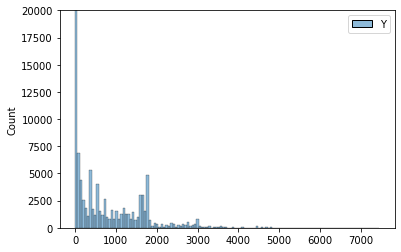

In [62]:
sns.histplot(data=merged_df[merged_df['CVSS v3.1 Ratings']=='Critical'][['Y']].dropna())
plt.ylim(0,20000)
plt.show()

<AxesSubplot: ylabel='Count'>

(0.0, 20000.0)

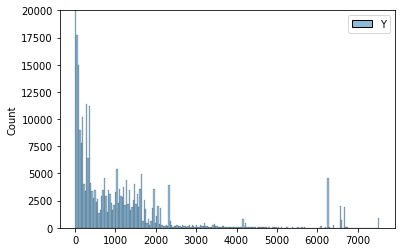

In [61]:
sns.histplot(data=merged_df[merged_df['CVSS v3.1 Ratings']=='High'][['Y']].dropna())
plt.ylim(0,20000)
plt.show()

<AxesSubplot: ylabel='Count'>

(0.0, 40000.0)

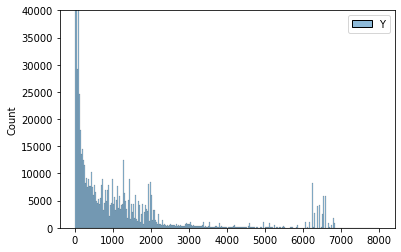

In [64]:
sns.histplot(data=merged_df[merged_df['CVSS v3.1 Ratings']=='Medium'][['Y']].dropna())
plt.ylim(0,40000)
plt.show()

In [50]:
def f_map(x):
    a = x['CVSS v3.1 Ratings']
    if a == 'None':
        return 1
    if a == 'Low':
        return 2
    if a == 'Medium':
        return 3
    if a == 'High':
        return 4
    if a == 'Critical':
        return 5
    else:
        return 0

condition_names = {1: 'None', 2: 'Low', 3: 'Medium', 4: 'High', 5: 'Critical', 0: 'no CVSS Ranking'}

merged_df['E']=True
merged_df['Y']=merged_df['cve_lifespan_commiter_time'].dt.days
#df_merged['Z']=df_merged['CVSS v3.1 Ratings']

S1, S2 = apply_stats_for_each_value(merged_df[:30000], f_map, condition_names)
display(S1), display(S2)

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,30000.0,1.0,62.0,0.169863,0.03,NaN,NaN


,count,median,min,max,std
agg,,,,,
Low,1173,83.0,0,2117,598.898844
Medium,23544,62.0,0,3544,669.329261
High,3509,24.0,0,4124,1018.899782
Critical,1774,119.0,0,3214,543.852145


(None, None)

In [59]:
S1, S2 = apply_stats_for_each_value(merged_df[:60000], f_map, condition_names)
display(S1), display(S2)

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,60000.0,1.0,79.0,0.216438,0.01,NaN,NaN


,count,median,min,max,std,mean
agg,,,,,,
no CVSS Ranking,653,2103.0,148,2971,646.470018,1756.618683
Low,2721,160.0,0,4209,730.801737,476.484013
Medium,45232,70.0,0,4125,729.789338,393.692165
High,6223,24.0,0,4124,1029.376083,570.430821
Critical,5171,119.0,0,4945,954.175383,587.660801


(None, None)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(f_map, axis=1)}).dropna()
selected_count = dff.shape[0]


for value in dff["agg"].unique():
    mask = dff["agg"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask],
                                                           dff["Y"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",